# LFHCal HGCROC Readout Waveform Fitting
The HGCROC took data in a sampled mode during the September 2024 LHFCal CERN PS test beam.  This notebook will look at the the ADC waveform collected, and attempt to extract a MIP from it.

I'll largely use run 305, which was a $\mu^+$ run with 2047 triggers.  The `h2g_decode` software is able to pull 1965 events from the run, which I'll call reasonable for now.  I'm not sure where the events are being lost, but that's for another time.  Another option is run 277, which is another $\mu^+$ run using the small scintillator pointed at a single tile.

In [1]:
import ROOT

ROOT.gStyle.SetOptStat(0)

# configuration variables
num_channels = 576
num_samples = 10

# Text class to use
text = ROOT.TLatex()
text.SetTextFont(42)
text.SetTextSize(0.12)

file = ROOT.TFile("run305.root")
tree = file.Get("events")

Welcome to JupyROOT 6.30/02


Each event is its own entry in the `events` tree.  The structure for ADC values is a 2D array, `adc[576][10]`, holding the 576 channels and 10 samples per channel.

In [2]:
adc_waveform = ROOT.TH2D("adc_waveform", "ADC waveform;Sample;ADC;Count", num_samples, 0, num_samples, 1024, 0, 1024)
for event in tree:
    for channel in range(num_channels):
        for sample in range(num_samples):
            # adc is seen as a 1D array for some reason, so we need to calculate the index
            index = channel * num_samples + sample
            adc_waveform.Fill(sample, event.adc[index])

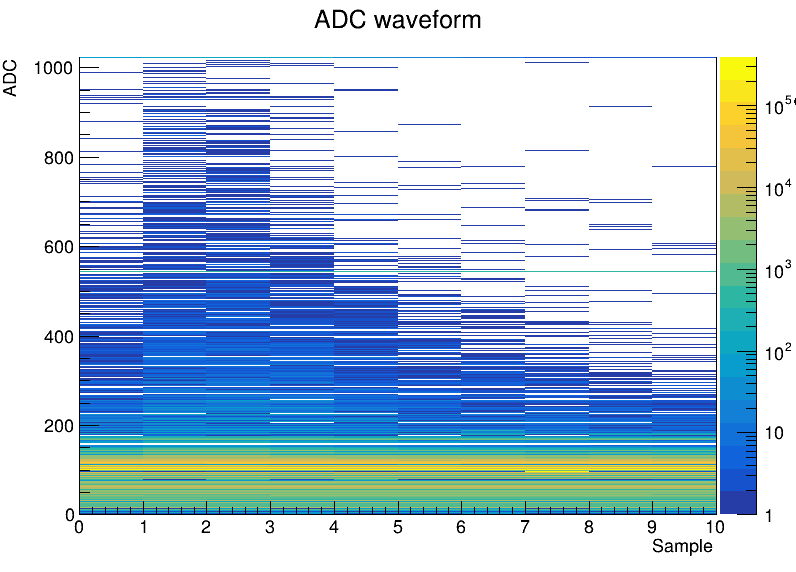

In [3]:
canvas = ROOT.TCanvas("canvas", "canvas", 800, 600)
adc_waveform.Draw("colz")
canvas.SetLogz()
canvas.Draw()

There are a few ideas for how to get the signal out of this.  The simplest is to look at the difference between the largest ADC value and some pedestal value, probably based off the first and last sample.  The fact that the signal seems to be peaking at a very eraly sample does make me a bit concerned about if this could work.  It's simple though, so let's try it first.  I'll use the last sample as the so called pedestal balue I think.

In [4]:
# Calculate the signal as the difference between the largest sample and the last sample
pedestal_subtracted_signal = ROOT.TH1D("pedestal_subtracted_signal", "Pedestal subtracted signal;ADC;Count", 1024, 0, 1024)
for event in tree:
    for channel in range(num_channels):
        max_sample = 0
        for sample in range(num_samples - 1):
            index = channel * num_samples + sample
            if event.adc[index] > max_sample:
                max_sample = event.adc[index]
        pedestal_subtracted_signal.Fill(max_sample - event.adc[channel * num_samples + num_samples - 1])

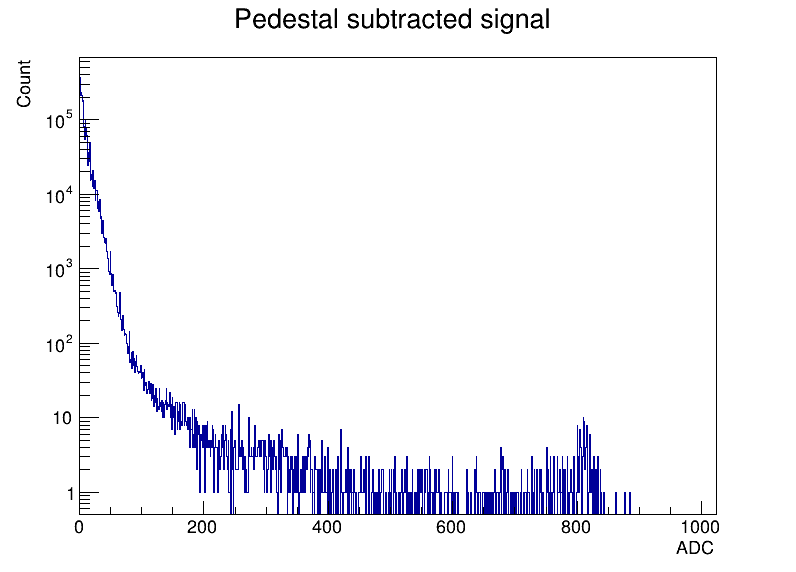

In [5]:
canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 600)
pedestal_subtracted_signal.Draw()
canvas2.SetLogy()
canvas2.Draw()


Well that doesn't look like a MIP peak.  There are a few issues here still I think, one is the two sharp peaks around 125 and 160 ADC.  I guess there's a tiny tiny chance that's a signal, but I don't believe it.  Let me try plotting this channel by channel.

In [6]:
per_channel_subtracted_signal = []
for channel in range(num_channels):
    hist = ROOT.TH1D(f"channel_{channel}_ped_subtracted", f"Channel {channel} pedestal subtracted signal", 1024, 0, 1024)
    per_channel_subtracted_signal.append(hist)
        
for event in tree:
    for channel in range(num_channels):
        max_sample = 0
        for sample in range(num_samples - 1):
            index = channel * num_samples + sample
            if event.adc[index] > max_sample:
                max_sample = event.adc[index]
        per_channel_subtracted_signal[channel].Fill(max_sample - event.adc[channel * num_samples + num_samples - 1])

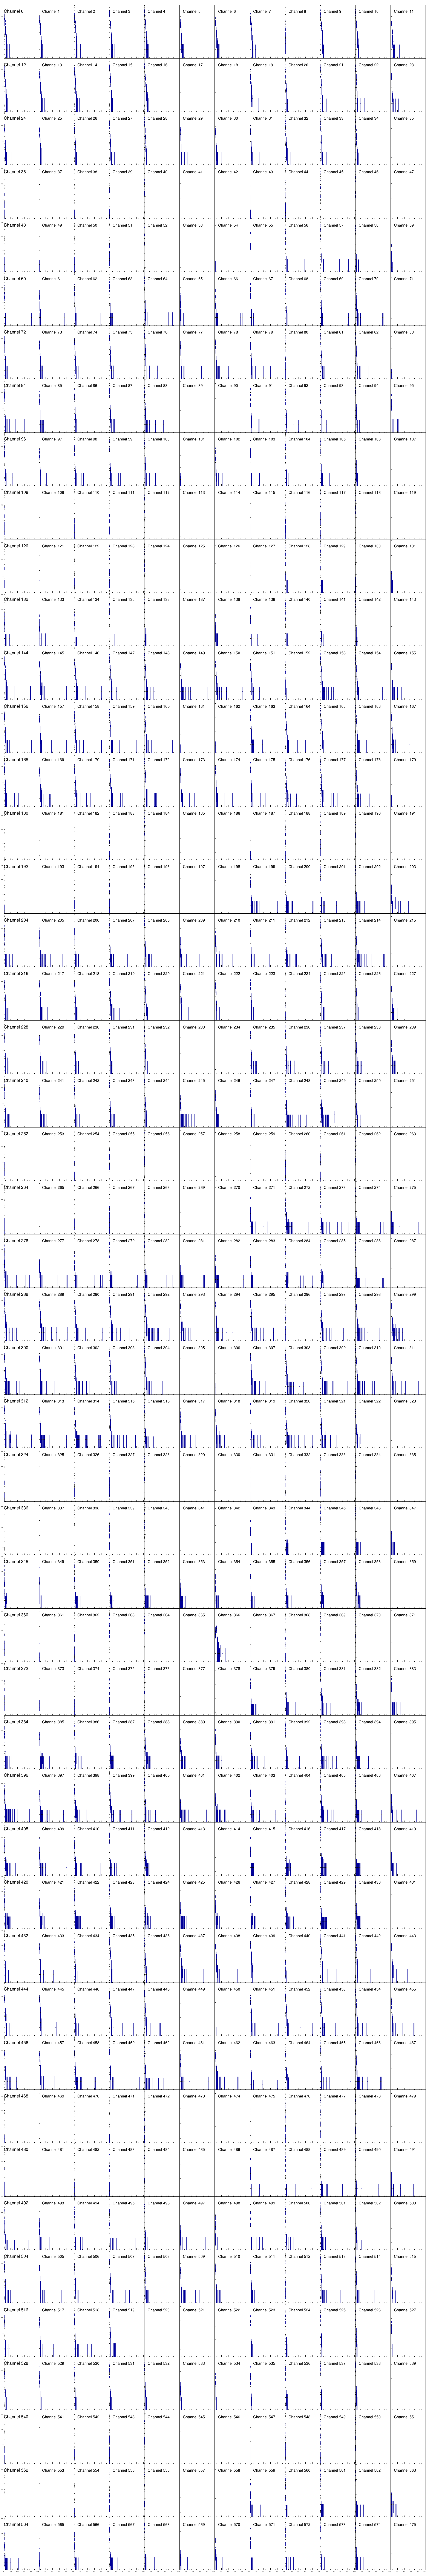

In [7]:
canvas3 = ROOT.TCanvas("canvas3", "Canvas 3", 2000, 12000)
width = 12
height =  int(num_channels / width)
canvas3.Divide(width, height, 0, 0)
for i in range(num_channels):
    canvas3.cd(i + 1)
    title = per_channel_subtracted_signal[i].GetTitle()
    per_channel_subtracted_signal[i].SetTitle("")
    per_channel_subtracted_signal[i].Draw("e")
    text.DrawLatexNDC(0.1, 0.85, f"Channel {i}")
    ROOT.gPad.SetLogy()
    canvas3.SetLeftMargin(0)
    canvas3.SetRightMargin(0)
    canvas3.SetTopMargin(0)
    canvas3.SetBottomMargin(0)
canvas3.Draw()

I think part of the issue I'm seeing here is just how large the pedestals are.  It seems like they peak around 75 ADC, but have a width of about that much too.  So what if rather than using the last value as the pedestal I just state it to be 75?  And then we only look at signals more than 2*75 above the pedestal?

In [8]:
# Calculate the signal as the difference between the largest sample and the last sample
pedestal_subtracted_signal = ROOT.TH1D("pedestal_subtracted_signal", "Pedestal subtracted signal;ADC;Count", 1024, 0, 1024)
for event in tree:
    for channel in range(num_channels):
        max_sample = 0
        for sample in range(num_samples - 1):
            index = channel * num_samples + sample
            if event.adc[index] > max_sample:
                max_sample = event.adc[index]
        if max_sample > 200:
            pedestal_subtracted_signal.Fill(max_sample - event.adc[channel * num_samples + num_samples - 1])

Warning in <TFile::Append>: Replacing existing TH1: pedestal_subtracted_signal (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


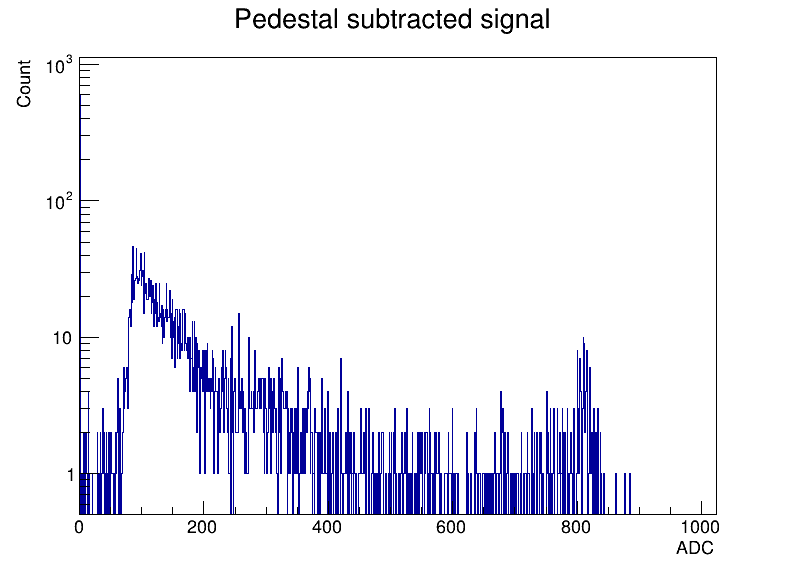

In [9]:
canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 600)
pedestal_subtracted_signal.Draw()
canvas2.SetLogy()
canvas2.Draw()

In [10]:
per_channel_subtracted_signal_2 = []
for channel in range(num_channels):
    hist = ROOT.TH1D(f"channel_{channel}_ped_subtracted_2", f"Channel {channel} pedestal subtracted signal", 1024, 0, 1024)
    per_channel_subtracted_signal_2.append(hist)
        
for event in tree:
    for channel in range(num_channels):
        max_sample = 0
        for sample in range(num_samples - 1):
            index = channel * num_samples + sample
            if event.adc[index] > max_sample:
                max_sample = event.adc[index]
        if max_sample > 200:
            per_channel_subtracted_signal_2[channel].Fill(max_sample - 75)

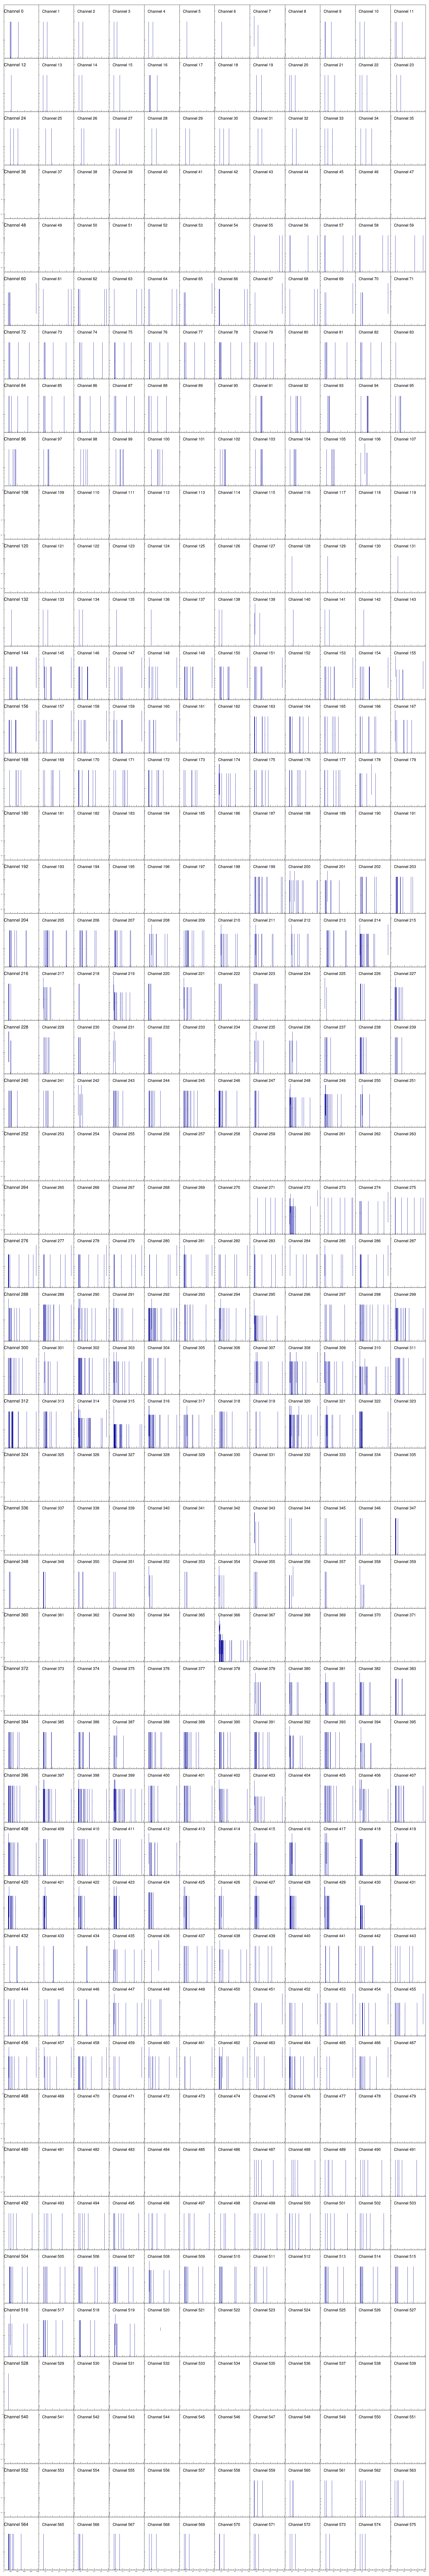

In [11]:
canvas4 = ROOT.TCanvas("canvas4", "Canvas 3", 2000, 12000)
width = 12
height =  int(num_channels / width)
canvas4.Divide(width, height, 0, 0)
for i in range(num_channels):
    canvas4.cd(i + 1)
    title = per_channel_subtracted_signal_2[i].GetTitle()
    per_channel_subtracted_signal_2[i].SetTitle("")
    per_channel_subtracted_signal_2[i].Draw("e")
    text.DrawLatexNDC(0.1, 0.85, f"Channel {i}")
    ROOT.gPad.SetLogy()
    canvas4.SetLeftMargin(0)
    canvas4.SetRightMargin(0)
    canvas4.SetTopMargin(0)
    canvas4.SetBottomMargin(0)
canvas4.Draw()

I'm thinking the best way to do this would be to do a fit to the data, and extract the peak from that.  This way the fluctuating pedestals can be better dealt with... is it consistent within a single event maybe?  That should be easy to check.  Also these memory accesses are so slow, I don't really believe that should be the case.  What am I doing wrong?

In [12]:
pedestal_consistency = ROOT.TH2D("pedestal_consistency", "Pedestal Consistency;Sample 0 ADC;Remaining samples ADC", 20, 0, 200, 20, 0, 200)
for event in tree:
    for channel in range(num_channels):
        sample_0_index = channel * 10
        for sample in range(1, num_samples):
            index = sample_0_index + sample
            pedestal_consistency.Fill(event.adc[sample_0_index], event.adc[index])
    


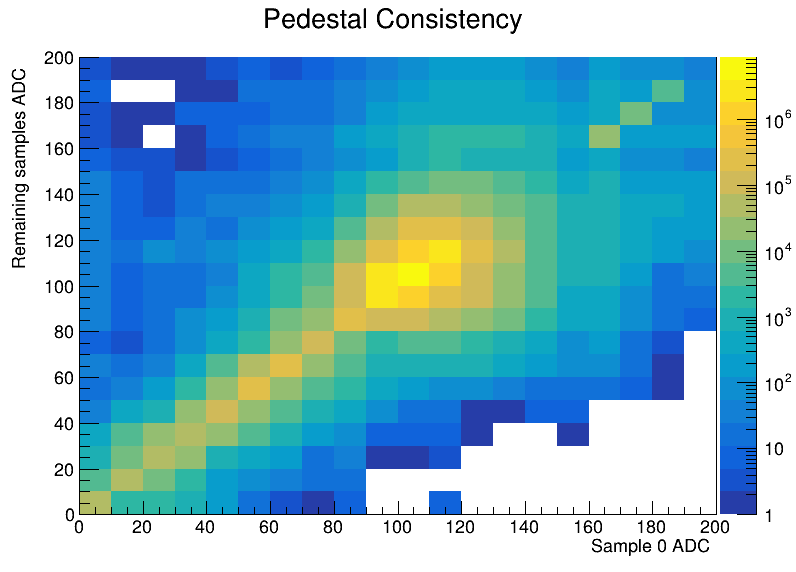

In [13]:
canvas5 = ROOT.TCanvas("canvas5", "Canvas 5", 800, 600)
pedestal_consistency.Draw("colz")
canvas5.SetLogz()
canvas5.Draw()

Okay, so it looks like in geenral the pedestals don't drift a lot sample to sample, the diagonal is the hottest line.

So I guess I need to try fitting waveforms.  